In [1]:
import pandas as pd
import os

# Define file paths
drug_cids_path = "data/drug_cids.csv"
pubchem_path = "data/pubchem_data.csv"
ddinter_path = "data/ddinter_downloads_code_A.csv"

# Load DataFrames
drug_cids_df = pd.read_csv(drug_cids_path)
pubchem_df = pd.read_csv(pubchem_path)
ddinter_df = pd.read_csv(ddinter_path)

# Data Preprocessing
# Rename 'CIDs' to 'cid' in drug_cids_df
drug_cids_df.rename(columns={'CIDs': 'cid'}, inplace=True)

# Drop rows with missing CIDs in drug_cids_df
drug_cids_df.dropna(subset=['cid'], inplace=True)

# Filter and map 'Level' column in ddinter_df
ddinter_df = ddinter_df[['Drug_A', 'Drug_B', 'Level']]
ddinter_df = ddinter_df[ddinter_df['Level'] != 'Unknown']
level_mapping = {'Minor': 0, 'Moderate': 1, 'Major': 2}
ddinter_df['Level'] = ddinter_df['Level'].map(level_mapping).astype(int)

# Select relevant columns from pubchem_df
columns_to_keep = [
    'cid', 'mw', 'polararea', 'complexity', 'heavycnt', 'hbonddonor', 'hbondacc',
    'rotbonds', 'exactmass', 'monoisotopicmass', 'charge', 'covalentunitcnt', 
    'isotopeatomcnt', 'totalatomstereocnt', 'definedatomstereocnt', 'undefinedatomstereocnt',
    'totalbondstereocnt', 'definedbondstereocnt', 'undefinedbondstereocnt'
]
pubchem_df = pubchem_df[columns_to_keep]

# Merge DataFrames
# Merge for Drug_A
ddinter_drugA_joined = pd.merge(ddinter_df, drug_cids_df, left_on='Drug_A', right_on='Drug Name', how='inner')
ddinter_drugA_joined = pd.merge(ddinter_drugA_joined, pubchem_df, on='cid', how='inner')
drug_a_columns = ['cid'] + list(pubchem_df.columns)
ddinter_drugA_joined = ddinter_drugA_joined.rename(columns={col: f"{col}_A" for col in drug_a_columns})

# Merge for Drug_B
ddinter_drugA_drugB_joined = pd.merge(ddinter_drugA_joined, drug_cids_df, left_on='Drug_B', right_on='Drug Name', how='inner')
ddinter_drugA_drugB_joined = pd.merge(ddinter_drugA_drugB_joined, pubchem_df, on='cid', how='inner')
drug_b_columns = ['cid'] + list(pubchem_df.columns)
ddinter_drugA_drugB_joined = ddinter_drugA_drugB_joined.rename(columns={col: f"{col}_B" for col in drug_b_columns})

# Drop unnecessary columns
columns_to_drop = ['Drug_A', 'Drug_B', 'Drug Name_x', 'Drug Name_y']
ddinter_drugA_drugB_joined.drop(columns=columns_to_drop, inplace=True)

# Drop columns with excessive missing values
ddinter_drugA_drugB_joined.drop(columns=['xlogp_A', 'xlogp_B'], inplace=True, errors='ignore')

Pipeline executed successfully. The merged dataset has been saved to: /Users/davidrogers/Downloads/ddinter_drugA_drugB_joined.csv


In [ ]:
# Step 1: Remove duplicate rows
ddinter_drugA_drugB_joined = ddinter_drugA_drugB_joined.drop_duplicates()
print(f"Duplicates removed. Remaining rows: {ddinter_drugA_drugB_joined.shape[0]}")

In [3]:
# Step 2: Check the distribution of 'Level'
level_counts = ddinter_drugA_drugB_joined['Level'].value_counts()
print(level_counts)

Checking the distribution of interaction levels...
Original distribution of Levels:
Level
1    1865871
2     348100
0     194664
Name: count, dtype: int64


In [4]:
# Step 3: Downsample the majority class (Level 1) to match Level 2
target_count = level_counts[2]  # Match Level 1 to the count of Level 2
balanced_df = pd.concat([
    ddinter_drugA_drugB_joined[ddinter_drugA_drugB_joined['Level'] == 0],
    ddinter_drugA_drugB_joined[ddinter_drugA_drugB_joined['Level'] == 1].sample(n=target_count, random_state=42),
    ddinter_drugA_drugB_joined[ddinter_drugA_drugB_joined['Level'] == 2]
])

# Step 4: Verify the new distribution
new_level_counts = balanced_df['Level'].value_counts()
print(new_level_counts)

Trimming the dataset to balance Level 1 with Level 2...
Verifying the new distribution of Levels...

Balanced distribution of Levels:
Level
1    348100
2    348100
0    194664
Name: count, dtype: int64


In [7]:
import sklearn
import xgboost
import lightgbm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [13]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix)

<function confusion_matrix at 0x12b7c8ae0>


In [8]:
# Step 5: Train-test split
X = balanced_df.drop(columns=['Level', 'cid_A', 'cid_B'])
y = balanced_df['Level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Performing train-test split...


In [9]:
# Step 6: Train and evaluate Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(classification_report(y_test, y_pred_rf))

Training Random Forest model...
Random Forest Results:
Accuracy: 0.9850

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     38858
           1       0.98      0.98      0.98     69625
           2       0.99      0.99      0.99     69690

    accuracy                           0.99    178173
   macro avg       0.98      0.98      0.98    178173
weighted avg       0.99      0.99      0.99    178173



Generating confusion matrix for Random Forest...


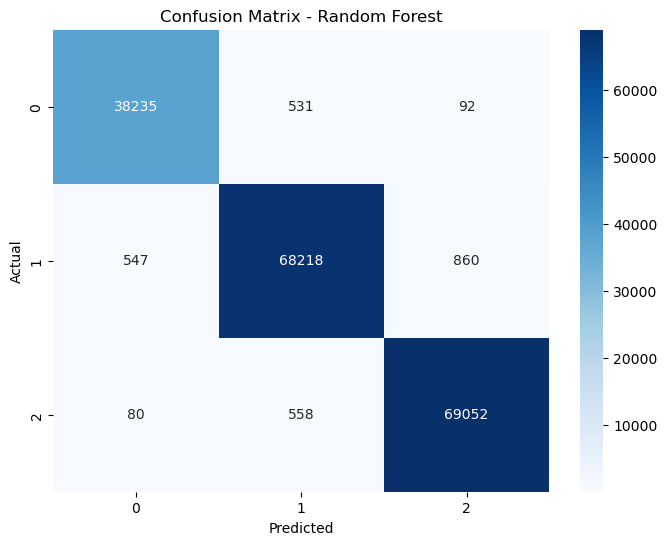

Plotting feature importance for Random Forest...


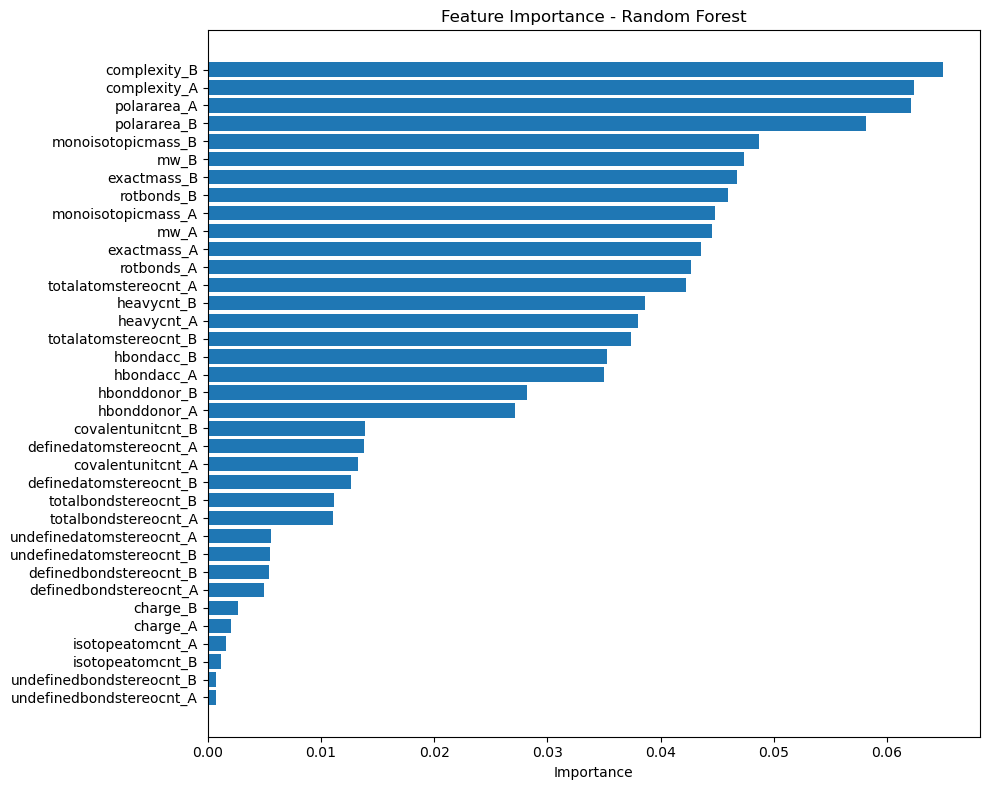

In [16]:
# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Feature Importance for Random Forest
rf_importance = rf_classifier.feature_importances_
feature_names = X.columns
sorted_idx = rf_importance.argsort()
plt.figure(figsize=(10, 8))
plt.barh(feature_names[sorted_idx], rf_importance[sorted_idx])
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


In [17]:
# Step 7: Train and evaluate XGBoost
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_classifier.fit(X_train, y_train)
y_pred_xgb = xgb_classifier.predict(X_test)
print("XGBoost Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

Training XGBoost model...


/Users/davidrogers/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:02:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Results:
Accuracy: 0.8765

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88     38858
           1       0.86      0.86      0.86     69625
           2       0.88      0.91      0.89     69690

    accuracy                           0.88    178173
   macro avg       0.88      0.87      0.88    178173
weighted avg       0.88      0.88      0.88    178173



Generating confusion matrix for XGBoost...


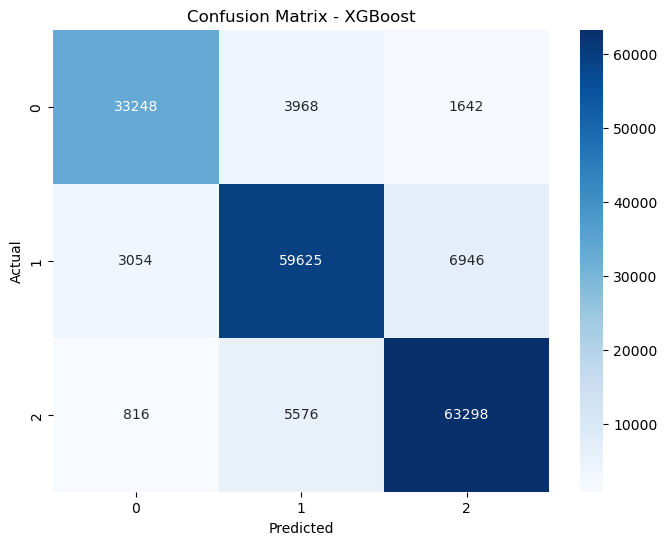

Plotting feature importance for XGBoost...


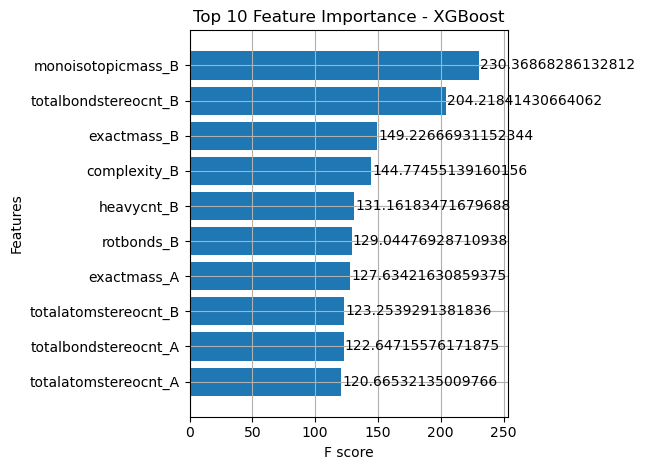

In [18]:
# Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Feature Importance for XGBoost
from xgboost import plot_importance
plot_importance(xgb_classifier, max_num_features=10, importance_type='gain', height=0.8)
plt.title('Top 10 Feature Importance - XGBoost')
plt.tight_layout()
plt.show()


In [19]:
# Step 8: Train and evaluate LightGBM
lgb_classifier = LGBMClassifier(learning_rate=0.3, n_estimators=1000, random_state=42)
lgb_classifier.fit(X_train, y_train)
y_pred_lgb = lgb_classifier.predict(X_test)
print("LightGBM Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lgb))

Training LightGBM model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.349127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3832
[LightGBM] [Info] Number of data points in the train set: 712691, number of used features: 36
[LightGBM] [Info] Start training from score -1.520436
[LightGBM] [Info] Start training from score -0.939720
[LightGBM] [Info] Start training from score -0.939953
LightGBM Results:
Accuracy: 0.9823

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     38858
           1       0.99      0.97      0.98     69625
           2       0.98      0.99      0.99     69690

    accuracy                           0.98    178173
   macro avg       0.98      0.98      0.98    178173
weighted avg       0.98      0.98      0.98    178173



Generating confusion matrix for LightGBM...


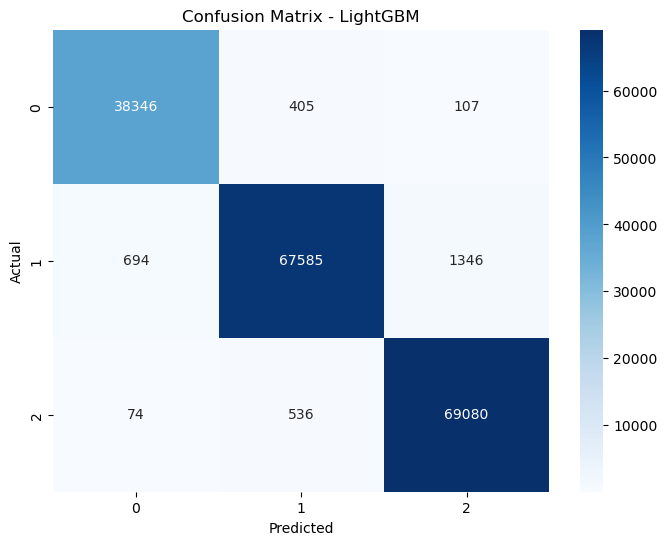

Plotting feature importance for LightGBM...


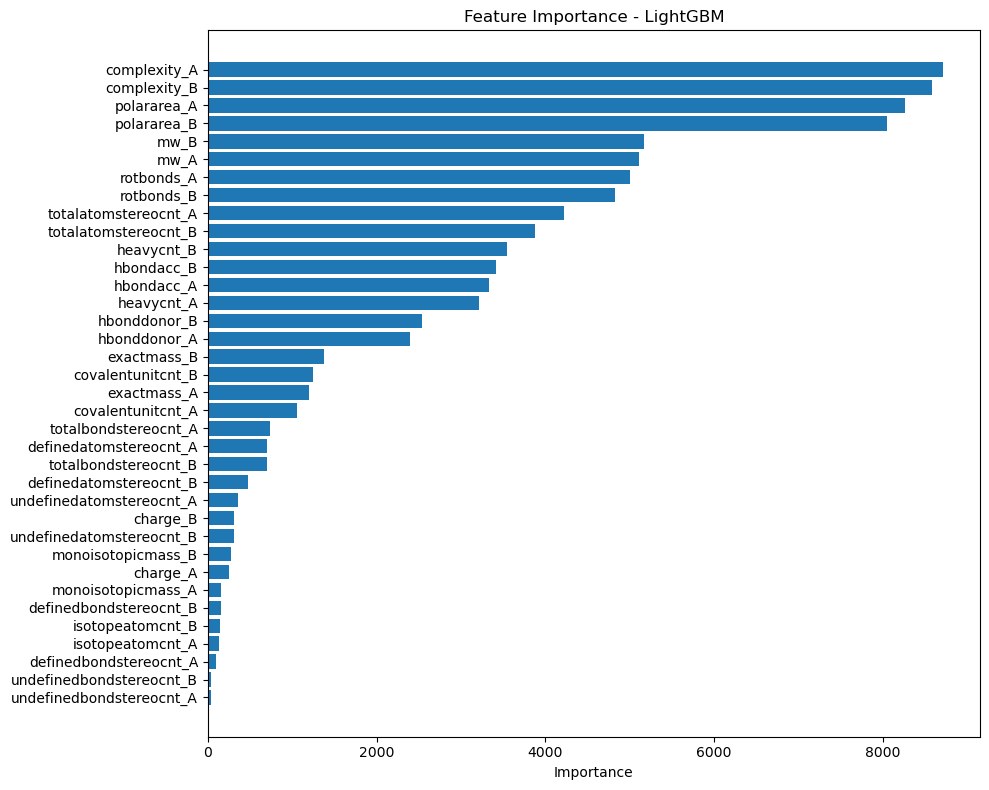

In [20]:
# Confusion Matrix for LightGBM
cm_lgb = confusion_matrix(y_test, y_pred_lgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - LightGBM')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Feature Importance for LightGBM
lgb_importance = lgb_classifier.feature_importances_
sorted_idx = lgb_importance.argsort()
plt.figure(figsize=(10, 8))
plt.barh(feature_names[sorted_idx], lgb_importance[sorted_idx])
plt.title('Feature Importance - LightGBM')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()